In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/X_USDINR.csv')
X.drop('Unnamed: 0', axis=1, inplace=True)
X.head()

,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0.002366,0.003777,0.002111,0.000000,0.000000,0.000000,0.0,0.435743,0.428316,0.501290,0.000988,0.000382,0.026881
1,0.002990,0.003444,0.005988,0.000148,0.000077,0.000040,0.0,0.440006,0.429330,0.511641,0.000988,0.000382,0.026881
2,0.000000,0.009943,0.006819,0.000310,0.000162,0.000085,0.0,0.443880,0.431063,0.518980,0.000988,0.000382,0.026881
3,0.000808,0.004527,0.006440,0.000284,0.000152,0.000080,0.0,0.441573,0.431901,0.509839,0.000988,0.000382,0.026881
4,0.003394,0.004238,0.001931,0.000529,0.000282,0.000148,0.0,0.447507,0.433982,0.522539,0.000988,0.000382,0.026881


In [3]:
y = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/Y_USDINR.csv')
y.drop('Unnamed: 0', axis=1, inplace=True)
y.head()

,Closing_price
0,61.400
1,61.495
2,61.508
3,61.391
4,61.565


In [4]:
import numpy as np

def evaluate_trading_metrics(y_true, y_pred, initial_capital=1000):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Ensure lengths match
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    # Compute directional accuracy
    true_diff = np.sign(np.diff(y_true))
    pred_diff = np.sign(np.diff(y_pred))
    correct = np.sum(true_diff == pred_diff)
    trading_accuracy = correct / len(true_diff) * 100

    # Simulate trading strategy
    capital = [initial_capital]
    for i in range(1, len(y_pred)):
        # If model says price will go up -> buy (position = +1)
        # If model says price will go down -> short (position = -1)
        position = 1 if y_pred[i] > y_pred[i - 1] else -1
        profit = position * (y_true[i] - y_true[i - 1])
        capital.append(capital[-1] + profit)

    capital = np.array(capital)
    returns = np.diff(capital) / capital[:-1]

    # ROI
    roi = (capital[-1] - initial_capital) / initial_capital * 100

    # Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) > 0 else 0

    # Max Drawdown
    peak = np.maximum.accumulate(capital)
    drawdown = (peak - capital) / peak
    max_drawdown = np.max(drawdown) * 100  # as a percentage

    return {
        "Trading Accuracy (%)": trading_accuracy,
        "ROI (%)": roi,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown
    }

In [14]:
def directional_accuracy(actual, predicted):
    # Ensure 1D arrays
    actual = np.ravel(actual)
    predicted = np.ravel(predicted)

    # Compute direction change
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare directions
    correct_direction = np.sign(actual_diff) == np.sign(pred_diff)

    return np.mean(correct_direction) * 100

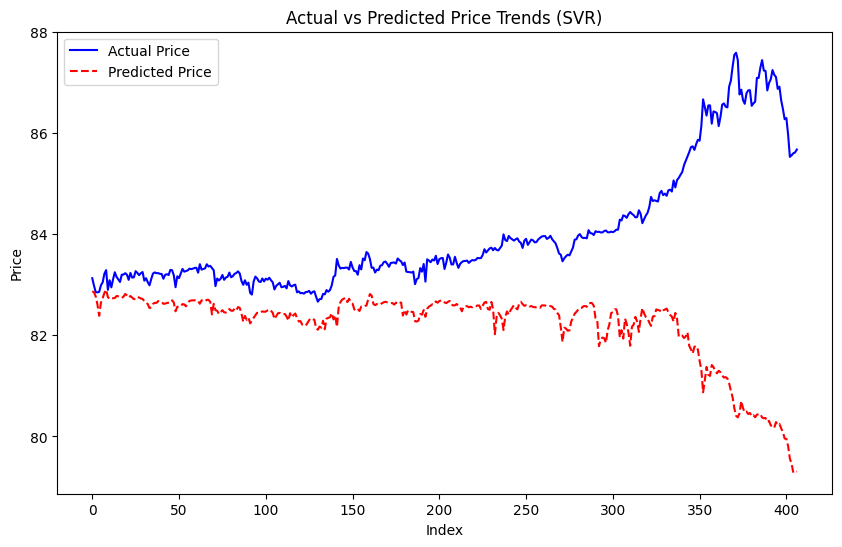

In [15]:
def svm_model(X, y):
    svm = SVR()
    
    total_size = len(X)
    train_end = int(total_size * 0.85)

    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[train_end:], y[train_end:]

    svm.fit(X_train, y_train)

    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Directional Accuracy
    dir_acc = directional_accuracy(y_test, y_test_pred)

    # Metrics dictionary
    svm_metrics = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)", 
            "Accuracy (1 - MAPE)",
            "Directional Accuracy (%)"
        ],
        "Training": [
            train_mae, 
            train_mse, 
            train_mape * 100, 
            train_r2, 
            (1 - train_mape) * 100,
            np.nan  # Not applicable for training
        ],
        "Testing": [
            test_mae, 
            test_mse, 
            test_mape * 100, 
            test_r2, 
            (1 - test_mape) * 100,
            dir_acc
        ]
    }

    svm_metrics_df = pd.DataFrame(svm_metrics)

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_test_pred)), y_test_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends (SVR)")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return svm_metrics_df, dir_acc

# Assuming X and y are defined
svm_metrics, directional_accuracy = svm_model(X, y)

In [16]:
svm_metrics

,Metric,Training,Testing
0,Mean Absolute Error (MAE),0.115657,1.796664
1,Mean Squared Error (MSE),0.024822,6.791548
2,Mean Absolute Percentage Error (MAPE),0.162834,2.107908
3,R-squared (R²),0.999278,-3.524384
4,Accuracy (1 - MAPE),99.837166,97.892092
5,Directional Accuracy (%),NaN,53.940887
